In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *
import numpy as np
np.random.seed(0)

### Inbound Costs
P is manufacturing plant. <br>D is distribution centre.

In [2]:
df_inbound = pd.read_csv('df_inprice.csv', index_col = 0)
df_inbound

,FROM,D1,D2
0,P1,3.0,5.0
1,P2,2.3,6.6


### Outbound Costs
S is store.

In [3]:
df_outbound = pd.read_csv('df_outprice.csv', index_col = 0)
df_outbound

,from,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
0,D1,2.30,4.23,2.26,3.38,1.59,2.01,5.32,6.63,2.38,...,5.86,8.30,3.02,1.01,2.77,2.96,3.53,8.60,2.77,7.06
1,D2,5.31,2.18,8.52,8.34,4.59,1.04,1.89,6.45,8.35,...,7.54,2.11,4.33,1.54,4.75,7.84,8.21,4.51,3.27,3.13


In [4]:
# Melting DataFrame
df_melt = pd.melt(df_outbound.set_index('from').T.reset_index(), id_vars=['index'], value_vars=['D1', 'D2'])
print("{:,} records".format(len(df_melt)))
df_melt

400 records


,index,from,value
0,S1,D1,2.30
1,S2,D1,4.23
2,S3,D1,2.26
3,S4,D1,3.38
4,S5,D1,1.59
...,...,...,...
395,S196,D2,7.84
396,S197,D2,8.21
397,S198,D2,4.51
398,S199,D2,3.27


### Plot Outbound Transportation Costs BoxPlot

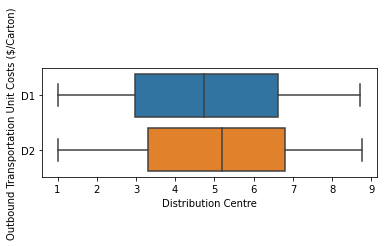

In [5]:
plt.figure(figsize = (6, 2))
ax = sns. boxplot(data = df_melt, x = 'value', y = 'from')
plt.xlabel('Distribution Centre')
plt.ylabel('Outbound Transportation Unit Costs ($/Carton)')
plt.show()

### Production Plant Capacity

In [6]:
df_prod = pd.DataFrame({
    'plant': ['P1','P2'],
    'max': [200, 300],
})[['plant', 'max']]
df_prod

,plant,max
0,P1,200
1,P2,300


### Distribution Centre docking capacity

In [7]:
# Cross-Docking Capacity
df_t = pd.DataFrame({
    'DC': ['D1','D2'],
    'CAPACITY': [450, 300]
})[['DC', 'CAPACITY']]
df_t

,DC,CAPACITY
0,D1,450
1,D2,300


### Demand Data

In [8]:
df_demand = pd.read_csv('df_demand.csv', index_col = 0)
print("{:,} total demand".format(df_demand.DEMAND.sum()))
df_demand.head()

31,806 total demand


,STORE,DEMAND
0,D1,244
1,D2,172
2,D3,124
3,D4,90
4,D5,158


### Build the Optimization Model


#### 1. Declare decision variables

In [9]:
model = LpProblem("Transhipment_Problem", LpMinimize)
# Inbound Flows
# I(i,j) from plant i for platform j
I = LpVariable.dicts("I", [(i+1,j+1) for i in range(2) for j in range(2)],
                     lowBound=0, upBound=None, cat='Integer') 
# Outbound Flows
# O(i,j) from platform i for customer j
O = LpVariable.dicts("O", [(i+1,j+1) for i in range(2) for j in range(200)],
                     lowBound=0, upBound=None, cat='Integer') 

#### 2. Declare objective function: total cost for transportation
> $
TC = \sum \limits _{n=1}^{n=2} \sum \limits _{p=1}^{p=2}
IC_{n,p} * I_{n,p} +
\sum \limits _{n=1}^{n=2} \sum \limits _{p=1}^{p=200}
OC_{n,p} * O_{n,p}
$

We want to minimize the inbound and outbound transportation costs.

In [10]:
model += lpSum([df_inbound.iloc[i,j+1] * I[i+1,j+1] for i in range(2) for j in range(2)]) + lpSum([df_outbound.iloc[i,j+1] * O[i+1,j+1] for i in range(2) for j in range(200)]) 

#### 3. Define the constraints: Total shipped from the 2 DCs higher than the demand
What are the limits in resources that will determine the feasibility in the region?
#### The supply from DCs needs to meet the demand per store.
> $
\forall p \in [1, 200] 
$
<br>
<br>
$
\sum \limits _{n=1}^{n=2} O_{n,p} \geq D _{p}
$

#### Total conservation of the flow.
> $
\forall p \in [1, 2] 
$
<br>
<br>
$
\sum \limits _{n=1}^{n=2} I_{n,p} = \sum \limits _{n=1}^{n=200} O_{n,p}
$

In [11]:
# Supply >= demand per store
for j in range(200):
    model += lpSum([O[i+1, j+1] for i in range(2)]) == df_demand.loc[j, 'DEMAND']

# Conservation of the flow in the local DC 
for p in range(2):
    model += lpSum([I[i+1, p+1] for i in range(2)]) == lpSum([O[p+1, j+1] for j in range (200)])

#### 4. Solve the model and analyse

In [12]:
status = model.solve()
print(LpStatus[status])
print("Objective: z* = {}".format(
    value(model.objective)))

Optimal
Objective: z* = 217189.3199999999


In [13]:
inbound, outbound = np.zeros([2,2]), np.zeros([2,200])
for i in range(2):
    for j in range(2):
        inbound[i, j] = I[i+1, j+1].varValue

for i in range(2):
    for j in range(200):
        outbound[i, j] = O[i+1, j+1].varValue

#### Results

In [14]:
df_resin = pd.DataFrame(data = inbound, index =['P' + str(i+1) for i in range(2)], 
                        columns = ['D' + str(i+1) for i in range(2)]).astype(int)
df_resin


,D1,D2
P1,0,6232
P2,25574,0


In [15]:
df_resout = pd.DataFrame(data = outbound, index =['D' + str(i+1) for i in range(2)], 
                        columns = ['S' + str(i+1) for i in range(200)])
df_resout.T

,D1,D2
S1,244.0,0.0
S2,172.0,0.0
S3,124.0,0.0
S4,90.0,0.0
S5,158.0,0.0
...,...,...
S196,57.0,0.0
S197,52.0,0.0
S198,0.0,243.0
S199,70.0,0.0


The model takes the cheapest route for Inbound by linking P2 with D1.
<br><br>
As expected, more than 90% of the Outbound is going through D1 to minimize Outbound Costs.

---
### Conclusion 
This methodology gives us the possibility to perform large scale optimization by implementing simple rules. We can improve the model by adding operational constraints:
- production costs in plants
- maximal docking capacity in DCs
- fixed/variable costs structure in DSs
- fixed + variable transportation costs structure y = (Ax+b)
Sadly, linear programming cannot do so as those constraints are non-linear.